Code Settings

In [269]:
seed=0
num_chosen_features_per_class = 200
max_fatures=1000
ngram_range_min=1
ngram_range_max=2
test_size= 0.2

Gathering the data

In [181]:
import numpy as np
import pandas as pd
import matplotlib

In [82]:
from pathlib import Path
import pandas as pd

In [83]:
Path().absolute().parent / "data"

WindowsPath('c:/Users/GUPTAAKI/Downloads/SpamClassBI/mlexercises/data')

In [84]:
DATA_DIR=Path().absolute().parent / "data"

In [85]:
DATA_PATH_1=DATA_DIR.joinpath("topic_train.csv")

In [86]:
DATA_PATH_2=DATA_DIR.joinpath("topic_valid.csv")

In [87]:
print(str(DATA_DIR))

c:\Users\GUPTAAKI\Downloads\SpamClassBI\mlexercises\data


In [88]:
print(str(DATA_PATH_1))

c:\Users\GUPTAAKI\Downloads\SpamClassBI\mlexercises\data\topic_train.csv


In [89]:
print(str(DATA_PATH_2))

c:\Users\GUPTAAKI\Downloads\SpamClassBI\mlexercises\data\topic_valid.csv


Processing the data

In [90]:
df_1=pd.read_csv(DATA_PATH_1)

In [91]:
df_2=pd.read_csv(DATA_PATH_2)

In [92]:
df_1

text  label
0      Here are Thursday's biggest analyst calls: App...      0
1      Buy Las Vegas Sands as travel to Singapore bui...      0
2      Piper Sandler downgrades DocuSign to sell, cit...      0
3      Analysts react to Tesla's latest earnings, bre...      0
4      Netflix and its peers are set for a ‘return to...      0
...                                                  ...    ...
16985  KfW credit line for Uniper could be raised to ...      3
16986  KfW credit line for Uniper could be raised to ...      3
16987  Russian  https://t.co/R0iPhyo5p7 sells 1 bln r...      3
16988  Global ESG bond issuance posts H1 dip as supra...      3
16989  Brazil's Petrobras says it signed a $1.25 bill...      3

[16990 rows x 2 columns]

In [93]:
df_2

text  label
0     Analyst call of the day for @CNBCPro subscribe...      0
1     Loop upgrades CSX to buy, says it's a good pla...      0
2     BofA believes we're already in a recession — a...      0
3     JPMorgan sees these derivative plays as best w...      0
4     Morgan Stanley's Huberty sees Apple earnings m...      0
...                                                 ...    ...
4112  Dollar bonds of Chinese developers fall as str...      3
4113  Longer maturity Treasury yields have scope to ...      3
4114  Pimco buys €1bn of Apollo buyout loans from ba...      3
4115  Analysis: Banks' snubbing of junk-rated loan f...      3
4116  U.S. Treasury seeks information on digital ass...      3

[4117 rows x 2 columns]

In [94]:
dataset_df = pd.concat([df_1,df_2]).reset_index(drop=True)

In [95]:
dataset_df

text  label
0      Here are Thursday's biggest analyst calls: App...      0
1      Buy Las Vegas Sands as travel to Singapore bui...      0
2      Piper Sandler downgrades DocuSign to sell, cit...      0
3      Analysts react to Tesla's latest earnings, bre...      0
4      Netflix and its peers are set for a ‘return to...      0
...                                                  ...    ...
21102  Dollar bonds of Chinese developers fall as str...      3
21103  Longer maturity Treasury yields have scope to ...      3
21104  Pimco buys €1bn of Apollo buyout loans from ba...      3
21105  Analysis: Banks' snubbing of junk-rated loan f...      3
21106  U.S. Treasury seeks information on digital ass...      3

[21107 rows x 2 columns]

In [96]:
dataset_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21107 entries, 0 to 21106
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    21107 non-null  object
 1   label   21107 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 329.9+ KB


In [97]:
dataset_df["label"].value_counts()

label
2     4397
18    2646
14    2237
9     1893
16    1234
5     1229
1     1051
19    1020
7      784
6      670
15     626
17     607
12     606
13     587
4      456
3      398
0      328
8      198
10      82
11      58
Name: count, dtype: int64

We are going to focus on one particular topic: "Company | Product News" (label 2)

So we are going to re-label:

Label 0: Not Company | Product News

Label 1: Company | Product News

So now the classification problem is a binary classification problem.

In [98]:
dataset_df_binary = dataset_df.copy()

In [99]:
#For the label column, it replaces all occurrences of '2' with '1'. Other values to 'NaN'
#Any value that was not '2' (and thus mapped to 'NaN') is then replaced with '0'.
#Finally, all values in the column are converted to integers ( 1 and 0).
dataset_df_binary["label"] = dataset_df_binary["label"].map({2:1}).fillna(0).map(int)

In [100]:
dataset_df_binary["label"].value_counts()

label
0    16710
1     4397
Name: count, dtype: int64

Preprocessing

In [101]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from num2words import num2words
from autocorrect import Speller

In [102]:
def text_preprocessing(input_text):
    
    def decode_encoding(text):
        # Remove start and end tags
        decoded_text = re.sub(r"<.*?>", "", input_text)
        # Replace newline characters with spaces
        decoded_text = re.sub(r'\n', ' ', decoded_text)
        # Normalize multiple spaces to a single space
        decoded_text = re.sub(r'\s+', ' ', decoded_text).strip()
        # Remove URLs
        decoded_text = re.sub(r'http\S+', "", decoded_text)

        return decoded_text
     
    def lowercase_text(text):
        return text.lower()

    def digits_to_words(match):
        suffixes = ['st', 'nd', 'rd', 'th']
        string=match[0].lower()   
        if string[-2:] in suffixes:
            type='ordinal'
            string = string[:-2]
        else:
            type='cardinal'

        return num2words(string, to=type)
    
    def remove_punctuation(text):
        return re.sub(r'[^\w\s]', '', text)

    def correct_spelling(text):
        corrector = Speller()
        spells = [corrector(word) for word in text.split()]
        return " ".join(spells)
     
    def remove_stopwords(text):
        stop_words = set(stopwords.words('english'))
        return ' '.join(word for word in text.split() if word not in stop_words)

    def perform_stemming(text):
        stemmer = PorterStemmer()
        return ' '.join(stemmer.stem(word) for word in text.split())
    
    def perform_lemmatization(text):
        lemmatizer = WordNetLemmatizer()
        return ' '.join(lemmatizer.lemmatize(word) for word in text.split())
    
    decoded_text = decode_encoding(input_text)
    
    lowercased_text = lowercase_text(decoded_text)
        
    digits_to_words_text = re.sub(r'\d+(st)?(nd)?(rd)?(th)?', digits_to_words, lowercased_text, flags=re.IGNORECASE)

    no_punctuation_text = remove_punctuation(digits_to_words_text)
    
    spelling_corrected_text = correct_spelling(no_punctuation_text)
    
    stopword_removed_text = remove_stopwords(spelling_corrected_text)
    
    stemmed_text = perform_stemming(stopword_removed_text)
   
    lemmatized_text = perform_lemmatization(stemmed_text)

    output= lemmatized_text
    
    return output

In [103]:
dataset_clean = dataset_df_binary.copy()
dataset_clean["text"]

0        Here are Thursday's biggest analyst calls: App...
1        Buy Las Vegas Sands as travel to Singapore bui...
2        Piper Sandler downgrades DocuSign to sell, cit...
3        Analysts react to Tesla's latest earnings, bre...
4        Netflix and its peers are set for a ‘return to...
                               ...                        
21102    Dollar bonds of Chinese developers fall as str...
21103    Longer maturity Treasury yields have scope to ...
21104    Pimco buys €1bn of Apollo buyout loans from ba...
21105    Analysis: Banks' snubbing of junk-rated loan f...
21106    U.S. Treasury seeks information on digital ass...
Name: text, Length: 21107, dtype: object

In [112]:
#Example
example_dataset = dataset_clean[:5]
example_dataset["text"] = [text_preprocessing(text) for text in example_dataset["text"]]
example_dataset

C:\Users\GUPTAAKI\AppData\Local\Temp\ipykernel_23384\3339106565.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  example_dataset["text"] = [text_preprocessing(text) for text in example_dataset["text"]]


text  label
0  thursday biggest analyst call appl amazon tesl...      0
1  buy la vega sand travel singapor build well ca...      0
2  piper handler downgrad focus sell cite elev ri...      0
3  analyst react tesla latest earn break what nex...      0
4  netflix peer set return growth analyst say giv...      0

In [116]:
dataset_clean.info

<bound method DataFrame.info of                                                     text  label
0      thursday biggest analyst call appl amazon tesl...      0
1      buy la vega sand travel singapor build well ca...      0
2      piper handler downgrad focus sell cite elev ri...      0
3      analyst react tesla latest earn break what nex...      0
4      netflix peer set return growth analyst say giv...      0
...                                                  ...    ...
21102  Dollar bonds of Chinese developers fall as str...      0
21103  Longer maturity Treasury yields have scope to ...      0
21104  Pimco buys €1bn of Apollo buyout loans from ba...      0
21105  Analysis: Banks' snubbing of junk-rated loan f...      0
21106  U.S. Treasury seeks information on digital ass...      0

[21107 rows x 2 columns]>

In [120]:
dataset_clean["text"] = [text_preprocessing(text) for text in dataset_clean["text"]]


In [121]:
dataset_clean

text  label
0      thursday biggest analyst call appli amazon tes...      0
1      buy la vega sand travel singapor build well ca...      0
2      piper handler download focu sell cite elev ris...      0
3      analyst react tesla latest earn break next ele...      0
4      netflix peer set return growth analyst say giv...      0
...                                                  ...    ...
21102  dollar bond chine develop fall stress spread j...      0
21103  longer matur treasuri yield scope go higher st...      0
21104               pico buy one apollo buyout loan bank      0
21105  analysi bank stab junkrat loan fund worsen fin...      0
21106            u treasuri seek inform digit asset risk      0

[21107 rows x 2 columns]

In [122]:

dataset_clean.head(10)

text  label
0  thursday biggest analyst call appli amazon tes...      0
1  buy la vega sand travel singapor build well ca...      0
2  piper handler download focu sell cite elev ris...      0
3  analyst react tesla latest earn break next ele...      0
4  netflix peer set return growth analyst say giv...      0
5  bare believ earn underperform stock may surpri...      0
6     einstein upgrad alabama say share ralli twenti      0
7  analyst react netflix strong quarter point pot...      0
8      buy chevron share look attract level hsbc say      0
9  morgan stanley say global stock set earn beat ...      0

In [123]:

dataset_clean.head(10).style.set_properties(**{'text-align': 'left'})

Preliminary data exploration

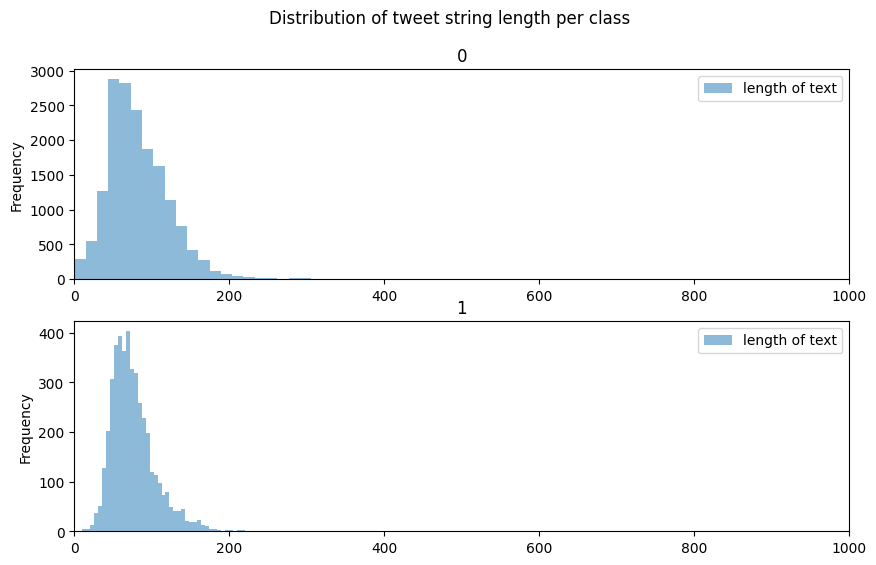

In [124]:
dataset_clean["length of text"] = dataset_clean["text"].map(len)
ax = dataset_clean.plot.hist(column=["length of text"], by="label", bins=50, alpha=0.5, figsize=(10, 6), title="Distribution of tweet string length per class", xlim=[0, 1000])
     

Feature engineering

In [125]:
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer

In [268]:
def feat_eng_text_df(in_df, text_col, labels_col):
    print("Feature Engineering method: Binary (one hot encoding)")
    countvectorizer = CountVectorizer(ngram_range=(ngram_range_min, ngram_range_max),
                                      stop_words='english',
                                      max_features=max_fatures,
                                      binary=True)

  

    out_arr = countvectorizer.fit_transform(in_df[text_col])
    count_tokens = countvectorizer.get_feature_names_out()
    out_df = pd.DataFrame(data = out_arr.toarray(),columns = count_tokens)
    out_df[labels_col] = list(in_df[labels_col])
    return out_df


dataset_feat_eng = feat_eng_text_df(dataset_clean, 'text', 'label')

Feature Engineering method: Binary (one hot encoding)


Exploring the new numerical features

In [127]:
dataset_feat_eng

aap  ab  acceler  access  accord  account  acquir  acquisit  act  \
0        0   0        0       0       0        0       0         0    0   
1        0   0        0       0       0        0       0         0    0   
2        0   0        0       0       0        0       0         0    0   
3        0   0        0       0       0        0       0         0    0   
4        0   0        0       0       0        0       0         0    0   
...    ...  ..      ...     ...     ...      ...     ...       ...  ...   
21102    0   0        0       0       0        0       0         0    0   
21103    0   0        0       0       1        0       0         0    0   
21104    0   0        0       0       0        0       0         0    0   
21105    0   0        0       0       0        0       0         0    0   
21106    0   0        0       0       0        0       0         0    0   

       action  ...  yield  york  yy  zero  zerof  zerofour  zeroseven  \
0           0  ...      0     0   0     0      0         0          0   
1           0  ...      0     0   0     0      0         0          0   
2           0  ...      0     0   0     0      0         0          0   
3           0  ...      0     0   0     0      0         0          0   
4           0  ...      0     0   0     0      0         0          0   
...       ...  ...    ...   ...  ..   ...    ...       ...        ...   
21102       0  ...      0     0   0     0      0         0          0   
21103       0  ...      1     0   0     0      0         0          0   
21104       0  ...      0     0   0     0      0         0          0   
21105       0  ...      0     0   0     0      0         0          0   
21106       0  ...      0     0   0     0      0         0          0   

       zerothre  zerotwo  label  
0             0        0      0  
1             0        0      0  
2             0        0      0  
3             0        0      0  
4             0        0      0  
...         ...      ...    ...  
21102         0        0      0  
21103         0        0      0  
21104         0        0      0  
21105         0        0      0  
21106         0        0      0  

[21107 rows x 1001 columns]

In [138]:

dataset_feat_eng.describe()     

aap            ab       acceler        access        accord  \
count  21107.000000  21107.000000  21107.000000  21107.000000  21107.000000   
mean       0.003790      0.003269      0.005970      0.003980      0.016724   
std        0.061449      0.057083      0.077034      0.062961      0.128240   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.000000      0.000000      0.000000      0.000000      0.000000   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

            account        acquir      acquisit           act        action  \
count  21107.000000  21107.000000  21107.000000  21107.000000  21107.000000   
mean       0.003553      0.008149      0.008054      0.002748      0.008338   
std        0.059505      0.089905      0.089385      0.052350      0.090936   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.000000      0.000000      0.000000      0.000000      0.000000   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

       ...         yield          york            yy          zero  \
count  ...  21107.000000  21107.000000  21107.000000  21107.000000   
mean   ...      0.008386      0.006917      0.003316      0.004833   
std    ...      0.091192      0.082883      0.057494      0.069350   
min    ...      0.000000      0.000000      0.000000      0.000000   
25%    ...      0.000000      0.000000      0.000000      0.000000   
50%    ...      0.000000      0.000000      0.000000      0.000000   
75%    ...      0.000000      0.000000      0.000000      0.000000   
max    ...      1.000000      1.000000      1.000000      1.000000   

              zerof      zerofour     zeroseven      zerothre       zerotwo  \
count  21107.000000  21107.000000  21107.000000  21107.000000  21107.000000   
mean       0.003790      0.004785      0.003459      0.003411      0.004548   
std        0.061449      0.069011      0.058709      0.058307      0.067289   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.000000      0.000000      0.000000      0.000000      0.000000   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

              label  
count  21107.000000  
mean       0.208320  
std        0.406116  
min        0.000000  
25%        0.000000  
50%        0.000000  
75%        0.000000  
max        1.000000  

[8 rows x 1001 columns]

In [139]:
dataset_feat_eng.describe().loc[['min', 'max', 'mean']]     

aap        ab  acceler   access    accord   account    acquir  \
min   0.00000  0.000000  0.00000  0.00000  0.000000  0.000000  0.000000   
max   1.00000  1.000000  1.00000  1.00000  1.000000  1.000000  1.000000   
mean  0.00379  0.003269  0.00597  0.00398  0.016724  0.003553  0.008149   

      acquisit       act    action  ...     yield      york        yy  \
min   0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000   
max   1.000000  1.000000  1.000000  ...  1.000000  1.000000  1.000000   
mean  0.008054  0.002748  0.008338  ...  0.008386  0.006917  0.003316   

          zero    zerof  zerofour  zeroseven  zerothre   zerotwo    label  
min   0.000000  0.00000  0.000000   0.000000  0.000000  0.000000  0.00000  
max   1.000000  1.00000  1.000000   1.000000  1.000000  1.000000  1.00000  
mean  0.004833  0.00379  0.004785   0.003459  0.003411  0.004548  0.20832  

[3 rows x 1001 columns]

Split to Train/Test

In [270]:
dataset_feat_eng_test = dataset_feat_eng.sample(frac=test_size,random_state=seed)
dataset_feat_eng_train = dataset_feat_eng.drop(dataset_feat_eng_test.index)

Preliminary statistical analysis and feasibility study

In [142]:
# This process is perhaps the most valuable for the preliminary study prior to applying ML.
# This is where we measure the relationship between "X" and "Y" so to see whether there is a "correlation".

# Since neither X nor Y are numerical in their nature, 
# we seek to evaluate the statistical dependence between them, 
# so to know whether a model would have any "signal" to pick up on.

In [197]:
# P(feature | class)

means_by_class = dataset_feat_eng_train.groupby(by=["label"]).mean().T.sort_index() # T is to get the transpose of dataframe
means_by_class

label             0         1
aap        0.004269  0.002830
ab         0.003820  0.000283
acceler    0.005467  0.009904
access     0.002696  0.009055
accord     0.019997  0.004527
...             ...       ...
zerof      0.004718  0.000000
zerofour   0.006141  0.000000
zeroseven  0.004494  0.000000
zerothre   0.004419  0.000000
zerotwo    0.005842  0.000000

[1000 rows x 2 columns]

In [208]:
dataset_feat_eng

aap  ab  acceler  access  accord  account  acquir  acquisit  act  \
0        0   0        0       0       0        0       0         0    0   
1        0   0        0       0       0        0       0         0    0   
2        0   0        0       0       0        0       0         0    0   
3        0   0        0       0       0        0       0         0    0   
4        0   0        0       0       0        0       0         0    0   
...    ...  ..      ...     ...     ...      ...     ...       ...  ...   
21102    0   0        0       0       0        0       0         0    0   
21103    0   0        0       0       1        0       0         0    0   
21104    0   0        0       0       0        0       0         0    0   
21105    0   0        0       0       0        0       0         0    0   
21106    0   0        0       0       0        0       0         0    0   

       action  ...  yield  york  yy  zero  zerof  zerofour  zeroseven  \
0           0  ...      0     0   0     0      0         0          0   
1           0  ...      0     0   0     0      0         0          0   
2           0  ...      0     0   0     0      0         0          0   
3           0  ...      0     0   0     0      0         0          0   
4           0  ...      0     0   0     0      0         0          0   
...       ...  ...    ...   ...  ..   ...    ...       ...        ...   
21102       0  ...      0     0   0     0      0         0          0   
21103       0  ...      1     0   0     0      0         0          0   
21104       0  ...      0     0   0     0      0         0          0   
21105       0  ...      0     0   0     0      0         0          0   
21106       0  ...      0     0   0     0      0         0          0   

       zerothre  zerotwo  label  
0             0        0      0  
1             0        0      0  
2             0        0      0  
3             0        0      0  
4             0        0      0  
...         ...      ...    ...  
21102         0        0      0  
21103         0        0      0  
21104         0        0      0  
21105         0        0      0  
21106         0        0      0  

[21107 rows x 1001 columns]

In [154]:
# P(class, feature)/(P(class)P(feature))
# rewritten as:
# P(class | feature)/P(class)
# Or equivalently:
# P(feature | class)/P(feature)

In [198]:
print(set(means_by_class.columns))

{0, 1}


In [207]:
P_class = sorted([[c, np.mean(dataset_feat_eng["label"] == c)] for c in set(means_by_class.columns)])
P_class

[[0, np.float64(0.7916804851471076)], [1, np.float64(0.2083195148528924)]]

In [213]:
P_feature = sorted([[f, np.mean(dataset_feat_eng[f] > 0)] for f in dataset_feat_eng.columns if f != "label"])
P_feature

[['aap', np.float64(0.0037902117780831005)],
 ['ab', np.float64(0.0032690576585966743)],
 ['acceler', np.float64(0.005969583550480883)],
 ['access', np.float64(0.0039797223669872555)],
 ['accord', np.float64(0.01672430947079168)],
 ['account', np.float64(0.0035533235419529068)],
 ['acquir', np.float64(0.008148955322878666)],
 ['acquisit', np.float64(0.008054200028426588)],
 ['act', np.float64(0.0027479035391102477)],
 ['action', np.float64(0.008338465911782821)],
 ['activ', np.float64(0.005922205903254844)],
 ['actual', np.float64(0.004074477661439333)],
 ['ad', np.float64(0.0058274506088027665)],
 ['add', np.float64(0.005116785900412185)],
 ['addit', np.float64(0.0032690576585966743)],
 ['administr', np.float64(0.002700525891884209)],
 ['advanc', np.float64(0.005495807078220495)],
 ['advis', np.float64(0.002700525891884209)],
 ['africa', np.float64(0.003884967072535178)],
 ['agenc', np.float64(0.00303216942246648)],
 ['aggress', np.float64(0.002890036480788364)],
 ['ago', np.float64(0

In [214]:
P_feature_inv = [[f, 1/p] for f, p in P_feature]
P_feature_inv

[['aap', np.float64(263.8375)],
 ['ab', np.float64(305.8985507246377)],
 ['acceler', np.float64(167.515873015873)],
 ['access', np.float64(251.27380952380952)],
 ['accord', np.float64(59.79320113314448)],
 ['account', np.float64(281.4266666666667)],
 ['acquir', np.float64(122.71511627906976)],
 ['acquisit', np.float64(124.15882352941176)],
 ['act', np.float64(363.9137931034483)],
 ['action', np.float64(119.92613636363636)],
 ['activ', np.float64(168.85600000000002)],
 ['actual', np.float64(245.43023255813952)],
 ['ad', np.float64(171.60162601626018)],
 ['add', np.float64(195.4351851851852)],
 ['addit', np.float64(305.8985507246377)],
 ['administr', np.float64(370.2982456140351)],
 ['advanc', np.float64(181.95689655172416)],
 ['advis', np.float64(370.2982456140351)],
 ['africa', np.float64(257.4024390243902)],
 ['agenc', np.float64(329.796875)],
 ['aggress', np.float64(346.016393442623)],
 ['ago', np.float64(285.22972972972974)],
 ['agre', np.float64(222.17894736842106)],
 ['agreement',

In [215]:
P_class_arr = np.array(P_class)
P_feature_arr = np.array(P_feature)
P_feature_inv_arr = np.array(P_feature_inv)

In [216]:
P_class_arr

array([[0.        , 0.79168049],
       [1.        , 0.20831951]])

In [217]:
P_feature_arr

array([['aap', '0.0037902117780831005'],
       ['ab', '0.0032690576585966743'],
       ['acceler', '0.005969583550480883'],
       ...,
       ['zeroseven', '0.0034585682475008293'],
       ['zerothre', '0.0034111906002747905'],
       ['zerotwo', '0.00454825413369972']], dtype='<U32')

In [218]:
P_feature_inv_arr

array([['aap', '263.8375'],
       ['ab', '305.8985507246377'],
       ['acceler', '167.515873015873'],
       ...,
       ['zeroseven', '289.13698630136986'],
       ['zerothre', '293.15277777777777'],
       ['zerotwo', '219.86458333333334']], dtype='<U32')

In [220]:

# Multiplying a "column vector" of feature probablities with a "line vector" of
# class probilities to get a matrix where each element is a product of probabilities:
P_class_prod_P_feature_inv_arr = np.outer(P_feature_inv_arr[:, 1].astype(float), P_class_arr[:, 1].astype(float))
P_class_prod_P_feature_inv_arr

array([[208.875     ,  54.9625    ],
       [242.17391304,  63.72463768],
       [132.61904762,  34.8968254 ],
       ...,
       [228.90410959,  60.23287671],
       [232.08333333,  61.06944444],
       [174.0625    ,  45.80208333]])

In [222]:

P_class_given_feature = means_by_class.copy()
for feature_counter in range(len(P_class_given_feature)):
  for c in P_class_given_feature.columns:
    # Right hand side: P(feature | class) / P(feature)
    P_class_given_feature[c][feature_counter] = means_by_class[c][feature_counter] / P_feature_arr[feature_counter, 1].astype(float)
    

C:\Users\GUPTAAKI\AppData\Local\Temp\ipykernel_23384\1370173409.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  P_class_given_feature[c][feature_counter] = means_by_class[c][feature_counter] / P_feature_arr[feature_counter, 1].astype(float)
C:\Users\GUPTAAKI\AppData\Local\Temp\ipykernel_23384\1370173409.py:5: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][r

In [226]:
# We present the most indicative terms for class “0,” which is the class of tweets that don’t indicate a 
# company or product information, and we also present the terms that are most indicative of class “1,” 
# meaning, when a tweet is discussing information about a company or a product

In [162]:
#The terms that are most indicative of class "0":
P_class_given_feature.sort_values([0], ascending=False)[[0]].head(10)

label                     0
latest updat       1.414411
gasolin            1.402971
encourag investor  1.393258
upsid              1.380427
es_f               1.373492
contact firm       1.373492
slip               1.366464
earn releas        1.365944
worst              1.365247
spi px             1.365247

In [163]:
#The terms that are most indicative of class "1":
P_class_given_feature.sort_values([1], ascending=False)[[1]].head(10)

label                      1
launch              4.288488
partnership         4.242187
announc form        4.221977
uk regulatori       4.121902
regulatori announc  4.121902
introduc            4.076504
plc                 4.022331
award               3.998155
collabor            3.981702
unveil              3.981702

Feature selection

In [252]:
#Note that the process of feature selection is done on the training set.

In [169]:
# For each class, choose the most indicative features.
# Either maximize the:

# a-priori distribution P(feature | class), Max Liklihood
# or
# a posteriori P(class | feature), MAP

In [251]:
#testing piece of code
print(means_by_class[0].sort_values(ascending=False).index[:201])
print(means_by_class[0].sort_values(ascending=False).index[:201])

Index(['thousand', 'market', 'stock', 'hundr', 'twentytwo', 'earn',
       'thousand twentytwo', 'economi', 'trade', 'say',
       ...
       'tax', 'et', 'action', 'acquir', 'crypto', 'rate hike', 'secur',
       'investig', 'euro', 'fuel'],
      dtype='object', length=201)
Index(['thousand', 'market', 'stock', 'hundr', 'twentytwo', 'earn',
       'thousand twentytwo', 'economi', 'trade', 'say',
       ...
       'tax', 'et', 'action', 'acquir', 'crypto', 'rate hike', 'secur',
       'investig', 'euro', 'fuel'],
      dtype='object', length=201)


In [239]:
#testing piece of code
print(list(means_by_class[0].sort_values(ascending=False).index[:201]))
print(list(means_by_class[1].sort_values(ascending=False).index[:201]))


['thousand', 'market', 'stock', 'hundr', 'twentytwo', 'earn', 'thousand twentytwo', 'economi', 'trade', 'say', 'inflat', 'price', 'bank', 'invest', 'rate', 'new', 'busi', 'financ', 'result', 'year', 'report', 'quarter', 'stockmarket', 'second', 'announc', 'china', 'investor', 'second quarter', 'compani', 'financi', 'expect', 'presid', 'revenu', 'share', 'dividend', 'week', 'quarter thousand', 'buy', 'month', 'global', 'oil', 'energi', 'uk', 'fed', 'time', 'june', 'billion', 'high', 'growth', 'rise', 'big', 'twentytwo result', 'increas', 'ga', 'sale', 'declar', 'amp', 'ep', 'central', 'group', 'beat', 'accord', 'rais', 'hold', 'hike', 'day', 'ceo', 'industri', 'watch', 'econom', 'higher', 'minist', 'risk', 'said', 'biden', 'govern', 'central bank', 'spi', 'russia', 'sinc', 'open', 'recess', 'pre', 'make', 'suppli', 'juli', 'deal', 'like', 'plan', 'look', 'twentytwo earn', 'fall', 'point', 'dollar', 'set', 'futur', 'fund', 'european', 'europ', 'result earn', 'low', 'countri', 'thousand h

In [167]:

chosen_features = []

classes = means_by_class.columns
for c in classes:
    chosen_features += list(means_by_class[c].sort_values(ascending=False).index[:(num_chosen_features_per_class + 1)])

chosen_features = list(set(chosen_features))

In [253]:

chosen_features

['trial',
 'group',
 'target',
 'studi',
 'econom',
 'win',
 'tesla',
 'day',
 'receiv',
 'demand',
 'buy',
 'rais',
 'high',
 'risk',
 'capit',
 'best',
 'includ',
 'hous',
 'vehicl',
 'partnership',
 'success',
 'twentytwo',
 'present',
 'batteri',
 'china',
 'collabor',
 'fifti',
 'regulatori',
 'look',
 'drug',
 'becom',
 'data',
 'consum',
 'custom',
 'time',
 'hike',
 'close',
 'russian',
 'spi',
 'appoint',
 'acquir',
 'market',
 'fund',
 'form',
 'major',
 'plc',
 'biden',
 'russia',
 'govern',
 'power',
 'enter',
 'project',
 'remain',
 'nation',
 'lender',
 'dollar',
 'hire',
 'sustain',
 'rise',
 'inflat',
 'asset',
 'rate',
 'musk',
 'select',
 'cancer',
 'growth',
 'twentytwo earn',
 'provid',
 'action',
 'watch',
 'servic',
 'use',
 'public',
 'regulatori announc',
 'air',
 'cost',
 'cloud',
 'announc form',
 'busi',
 'work',
 'outlook',
 'deal',
 'et',
 'pre',
 'twenti',
 'agreement',
 'est',
 'expand',
 'report',
 'award',
 'said',
 'uk regulatori',
 'warn',
 'futur',
 

Leave only chosen features:


In [172]:
#Now that we deduced which features are "important" based on the train set, 
# we select them for both the train set and the test set.

In [260]:

dataset_feat_eng_train_selected = dataset_feat_eng_train.filter(chosen_features + ["label"])
dataset_feat_eng_test_selected = dataset_feat_eng_test.filter(chosen_features + ["label"])


In [261]:
dataset_feat_eng_train_selected.head()

trial  group  target  studi  econom  win  tesla  day  receiv  demand  ...  \
0      0      0       0      0       0    0      1    0       0       0  ...   
1      0      0       0      0       0    0      0    0       0       0  ...   
2      0      0       0      0       0    0      0    0       0       0  ...   
3      0      0       0      0       0    0      1    0       0       0  ...   
4      0      0       0      0       0    0      0    0       0       0  ...   

   rate hike  valu  ga  boe  order  revenu  cut  world  thousand hundr  label  
0          0     0   0    0      0       0    0      0               0      0  
1          0     0   0    0      0       0    0      0               0      0  
2          0     0   0    0      0       0    0      0               0      0  
3          0     0   0    0      0       0    0      0               0      0  
4          0     0   0    0      0       0    0      0               0      0  

[5 rows x 310 columns]

In [263]:
dataset_feat_eng_test_selected.head()

trial  group  target  studi  econom  win  tesla  day  receiv  demand  \
11951      0      0       0      0       0    0      0    0       0       0   
13497      0      0       0      0       0    0      0    0       0       0   
1991       0      0       0      1       0    0      0    0       0       0   
1191       0      0       0      0       0    0      0    0       0       0   
10061      0      0       0      0       0    0      0    0       0       0   

       ...  rate hike  valu  ga  boe  order  revenu  cut  world  \
11951  ...          0     0   0    0      0       0    0      0   
13497  ...          0     0   0    0      0       0    0      0   
1991   ...          0     0   0    0      0       0    0      0   
1191   ...          0     0   0    0      0       0    0      0   
10061  ...          0     0   0    0      0       0    0      0   

       thousand hundr  label  
11951               0      0  
13497               0      0  
1991                0      1  
1191                0      1  
10061               0      0  

[5 rows x 310 columns]

In [174]:

dataset_feat_eng_train_selected["label"].value_counts()

label
0    13352
1     3534
Name: count, dtype: int64

Machine Learning

In [175]:

dataset_feat_eng_train_selected.head()
     

trial  group  target  studi  econom  win  tesla  day  receiv  demand  ...  \
0      0      0       0      0       0    0      1    0       0       0  ...   
1      0      0       0      0       0    0      0    0       0       0  ...   
2      0      0       0      0       0    0      0    0       0       0  ...   
3      0      0       0      0       0    0      1    0       0       0  ...   
4      0      0       0      0       0    0      0    0       0       0  ...   

   rate hike  valu  ga  boe  order  revenu  cut  world  thousand hundr  label  
0          0     0   0    0      0       0    0      0               0      0  
1          0     0   0    0      0       0    0      0               0      0  
2          0     0   0    0      0       0    0      0               0      0  
3          0     0   0    0      0       0    0      0               0      0  
4          0     0   0    0      0       0    0      0               0      0  

[5 rows x 310 columns]

In [177]:
#Parse out the Y labels from the dataset, and change the variable type to suit the models.

In [264]:
x_features_train = dataset_feat_eng_train_selected.values[:, 0:-1]
y_labels_train = dataset_feat_eng_train_selected.values[:, -1]

x_features_test = dataset_feat_eng_test_selected.values[:, :-1]
y_labels_test = dataset_feat_eng_test_selected.values[:, -1]
     

Iterate over ML models

In [178]:
from sklearn.model_selection import cross_val_score, GridSearchCV, StratifiedKFold
import sklearn.linear_model as lm
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [272]:
models = []
models.append(("Random Forest", RandomForestClassifier(random_state=seed)))
models.append(("LASSO", lm.LogisticRegression(solver='liblinear', penalty='l1', max_iter=1000, random_state=seed)))
models.append(("KNN", KNeighborsClassifier()))
models.append(("Decision Tree", DecisionTreeClassifier(random_state=seed)))
models.append(("SVM", SVC(gamma='auto', random_state=0)))

models

[('Random Forest', RandomForestClassifier(random_state=0)),
 ('LASSO',
  LogisticRegression(max_iter=1000, penalty='l1', random_state=0,
                     solver='liblinear')),
 ('KNN', KNeighborsClassifier()),
 ('Decision Tree', DecisionTreeClassifier(random_state=0)),
 ('SVM', SVC(gamma='auto', random_state=0))]

In [179]:
results = []
names = []
best_mean_result = 0
best_std_result = 0

for name, model in models:
  kfold = StratifiedKFold()
  cv_results = cross_val_score(model, x_features_train, y_labels_train, scoring='accuracy', cv=kfold)
  results.append(cv_results)
  names.append(name)
  print(name + ": mean(accuracy)=" + str(round(np.mean(cv_results), 3)) + ", std(accuracy)=" + str(round(np.std(cv_results), 3)))
  if (best_mean_result < np.mean(cv_results)) or \
    ((best_mean_result == np.mean(cv_results)) and (best_std_result > np.std(cv_results))):
    best_mean_result = np.mean(cv_results)
    best_std_result = np.std(cv_results)
    best_model_name = name
    best_model = model
print("\nBest model is:\n" + best_model_name)

Random Forest: mean(accuracy)=0.841, std(accuracy)=0.037
LASSO: mean(accuracy)=0.852, std(accuracy)=0.027
KNN: mean(accuracy)=0.832, std(accuracy)=0.028
Decision Tree: mean(accuracy)=0.806, std(accuracy)=0.035
SVM: mean(accuracy)=0.804, std(accuracy)=0.007

Best model is:
LASSO


C:\Users\GUPTAAKI\AppData\Local\Temp\ipykernel_23384\649715771.py:1: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  matplotlib.pyplot.boxplot(results, labels=names)


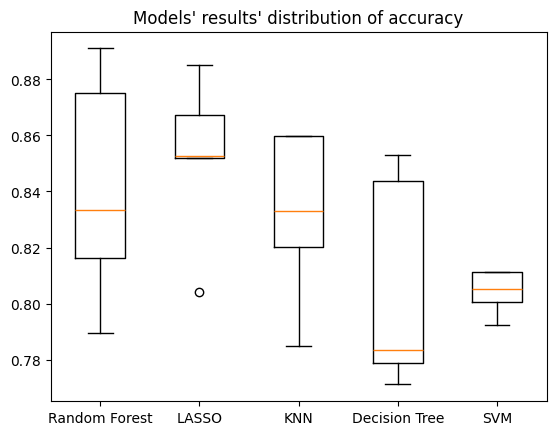

In [182]:
matplotlib.pyplot.boxplot(results, labels=names)
matplotlib.pyplot.title("Models' results' distribution of accuracy")
matplotlib.pyplot.show()
     

Generate the chosen model

In [183]:
#Optimize the hyperparameters:

In [276]:
model = lm.LogisticRegression(solver='liblinear', penalty='l1', max_iter=1000, random_state=seed)
params = {"C": np.linspace(start=0.001, stop=10, num=20)}
grid_search = GridSearchCV(model, params, scoring='accuracy')
grid_search.fit(x_features_train, y_labels_train)
print("The optimal hyperparameter 'C' is:", grid_search.best_params_["C"])

The optimal hyperparameter 'C' is: 1.0535263157894736


In [278]:
#Fit the optimized model to the training set:
model = lm.LogisticRegression(C=grid_search.best_params_["C"], max_iter=1000, random_state=seed)
model.fit(x_features_train, y_labels_train)

LogisticRegression(C=np.float64(1.0535263157894736), max_iter=1000,
                   random_state=0)

Generating the train results – design choices

In [280]:
y_train_estimated = model.predict(x_features_train)
accuracy_train = np.mean(y_train_estimated == y_labels_train)

# baseline accuracy, which can be considered the accuracy of a dummy classifier that always predicts 0(most frequent class)
baseline_accuracy_train = np.mean(0 == y_labels_train)

# accuracy lift, which is the percentage improvement of the model over the baseline
accuracy_lift_train = 100 * (accuracy_train/baseline_accuracy_train - 1)

print("Results on the train set:\n-------------------------")
print("Baseline (dummy classifier) accuracy:", round(baseline_accuracy_train, 2))
print("Current model's accuracy:", round(accuracy_train, 2))
print("The accuracy lift is:", round(accuracy_lift_train), "%")

Results on the train set:
-------------------------
Baseline (dummy classifier) accuracy: 0.79
Current model's accuracy: 0.88
The accuracy lift is: 12 %


Generate the test results: Use for presenting performance

In [281]:

y_test_estimated = model.predict(x_features_test)
accuracy_test = np.mean(y_test_estimated == y_labels_test)
baseline_accuracy_test = np.mean(0 == y_labels_test)
accuracy_lift = 100 * (accuracy_test/baseline_accuracy_test - 1)

print("Results on the test set:\n-------------------------")
print("Baseline (dummy classifier) accuracy:", round(baseline_accuracy_test, 2))
print("Current model's accuracy:", round(accuracy_test, 2))
print("The accuracy lift is:", round(accuracy_lift), "%")


Results on the test set:
-------------------------
Baseline (dummy classifier) accuracy: 0.8
Current model's accuracy: 0.88
The accuracy lift is: 10 %


In [283]:
print("\nConfusion Matrix:")
print(confusion_matrix(y_labels_test, y_test_estimated))


Confusion Matrix:
[[3219  139]
 [ 388  475]]


In [284]:
print("\nClassification Report:")
print(classification_report(y_labels_test, y_test_estimated))


Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.96      0.92      3358
           1       0.77      0.55      0.64       863

    accuracy                           0.88      4221
   macro avg       0.83      0.75      0.78      4221
weighted avg       0.87      0.88      0.87      4221

